<a href="https://colab.research.google.com/github/Kell1000/Big_data/blob/main/TP_PySpark_BigData_Colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# TP PySpark avec GPU T4 - Analyse Big Data E-Commerce

Maîtriser PySpark sur Google Colab avec accélération GPU pour analyser des données e-commerce à grande échelle

---

## Table des matières
1. Configuration de l'environnement
2. Chargement et exploration des données
3. Nettoyage et transformation
4. Analyses avancées
5. Machine Learning
6. Optimisation des performances
7. Dashboard et visualisations

---
## PARTIE 1: Configuration de l'environnement

In [1]:
# Installer PySpark et dépendances
!pip install pyspark kaggle findspark -q

print("Installation terminée!")

Installation terminée!


In [2]:
# Vérifier le GPU T4 disponible
!nvidia-smi

Thu Feb 19 10:46:39 2026       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 580.82.07              Driver Version: 580.82.07      CUDA Version: 13.0     |
+-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   37C    P8              9W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [3]:
# Imports
import findspark
findspark.init()

from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.sql.types import *
from pyspark.sql.window import Window
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.clustering import KMeans
from pyspark.ml.recommendation import ALS
from pyspark.ml.evaluation import RegressionEvaluator

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

warnings.filterwarnings('ignore')
sns.set_style('whitegrid')

print("Imports réussis!")

Imports réussis!


In [4]:
from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .appName("TP_BigData_Ecommerce") \
    .config("spark.executor.memory", "12g") \
    .config("spark.driver.memory", "12g") \
    .config("spark.executor.cores", "2") \
    .config("spark.sql.shuffle.partitions", "200") \
    .config("spark.sql.adaptive.enabled", "true") \
    .config("spark.sql.adaptive.coalescePartitions.enabled", "true") \
    .config("spark.ui.enabled", "true") \
    .getOrCreate()

print(f"Spark {spark.version} initialisé!")

ui_url = spark.sparkContext.uiWebUrl
if ui_url:
    print(f"Spark UI: {ui_url}")
else:
    print("Spark UI non disponible (environnement notebook/cluster).")
    print("Essaye: http://localhost:4040")


Spark 4.0.2 initialisé!
Spark UI: http://227d277c95eb:4040


### Téléchargement des données depuis Kaggle

In [5]:
# Uploader votre fichier kaggle.json
from google.colab import files

print("Veuillez uploader votre fichier kaggle.json")
uploaded = files.upload()

# Configurer Kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

print("Kaggle configuré!")

Veuillez uploader votre fichier kaggle.json


Saving kaggle.json to kaggle.json
Kaggle configuré!


In [6]:
# Télécharger le dataset
!kaggle datasets download -d mkechinov/ecommerce-behavior-data-from-multi-category-store
!unzip -q ecommerce-behavior-data-from-multi-category-store.zip
!ls -lh *.csv

print("Dataset téléchargé!")

Dataset URL: https://www.kaggle.com/datasets/mkechinov/ecommerce-behavior-data-from-multi-category-store
License(s): copyright-authors
 99% 4.27G/4.29G [01:09<00:00, 246MB/s]
100% 4.29G/4.29G [01:09<00:00, 66.0MB/s]
-rw-r--r-- 1 root root 8.4G Dec  9  2019 2019-Nov.csv
-rw-r--r-- 1 root root 5.3G Dec  9  2019 2019-Oct.csv
Dataset téléchargé!


---
## PARTIE 2: Chargement et exploration des données

In [8]:
# Définir le schéma pour optimiser le chargement
schema = StructType([
    StructField("event_time", TimestampType(), True),
    StructField("event_type", StringType(), True),
    StructField("product_id", IntegerType(), True),
    StructField("category_id", LongType(), True),
    StructField("category_code", StringType(), True),
    StructField("brand", StringType(), True),
    StructField("price", FloatType(), True),
    StructField("user_id", IntegerType(), True),
    StructField("user_session", StringType(), True)
])

# Charger les données
df = spark.read.csv(
    "2019-Oct.csv",
    header=True,
    schema=schema,
    timestampFormat="yyyy-MM-dd HH:mm:ss z"
)
df= df.limit(500000)
# Cacher en mémoire
df.cache()

print(f"Données chargées: {df.count():,} lignes")
print(f"Nombre de partitions: {df.rdd.getNumPartitions()}")

Données chargées: 500,000 lignes
Nombre de partitions: 1


In [9]:
# Explorer le schéma
df.printSchema()

root
 |-- event_time: timestamp (nullable = true)
 |-- event_type: string (nullable = true)
 |-- product_id: integer (nullable = true)
 |-- category_id: long (nullable = true)
 |-- category_code: string (nullable = true)
 |-- brand: string (nullable = true)
 |-- price: float (nullable = true)
 |-- user_id: integer (nullable = true)
 |-- user_session: string (nullable = true)



In [10]:
# Aperçu des données
df.show(10, truncate=False)

+-------------------+----------+----------+-------------------+-----------------------------------+--------+-------+---------+------------------------------------+
|event_time         |event_type|product_id|category_id        |category_code                      |brand   |price  |user_id  |user_session                        |
+-------------------+----------+----------+-------------------+-----------------------------------+--------+-------+---------+------------------------------------+
|2019-10-01 00:00:00|view      |44600062  |2103807459595387724|NULL                               |shiseido|35.79  |541312140|72d76fde-8bb3-4e00-8c23-a032dfed738c|
|2019-10-01 00:00:00|view      |3900821   |2053013552326770905|appliances.environment.water_heater|aqua    |33.2   |554748717|9333dfbd-b87a-4708-9857-6336556b0fcc|
|2019-10-01 00:00:01|view      |17200506  |2053013559792632471|furniture.living_room.sofa         |NULL    |543.1  |519107250|566511c2-e2e3-422b-b695-cf8e6e792ca8|
|2019-10-01 00:0

In [11]:
# Statistiques descriptives
df.describe().show()

+-------+----------+--------------------+--------------------+-------------------+------+------------------+--------------------+--------------------+
|summary|event_type|          product_id|         category_id|      category_code| brand|             price|             user_id|        user_session|
+-------+----------+--------------------+--------------------+-------------------+------+------------------+--------------------+--------------------+
|  count|    500000|              500000|              500000|             341561|428191|            500000|              500000|              500000|
|   mean|      NULL|   1.0104293028864E7|2.056138660692542...|               NULL|   NaN| 293.3028195955373|  5.31100161149738E8|                NULL|
| stddev|      NULL|1.1039791051590202E7|1.525755170891053...|               NULL|   NaN|365.72382924111315|1.6579605353176571E7|                NULL|
|    min|      cart|             1001588| 2053013552226107603|    accessories.bag|a-case|     

In [12]:
# Vérifier les valeurs manquantes
df.select([count(when(col(c).isNull(), c)).alias(c) for c in df.columns]).show()

+----------+----------+----------+-----------+-------------+-----+-----+-------+------------+
|event_time|event_type|product_id|category_id|category_code|brand|price|user_id|user_session|
+----------+----------+----------+-----------+-------------+-----+-----+-------+------------+
|         0|         0|         0|          0|       158439|71809|    0|      0|           0|
+----------+----------+----------+-----------+-------------+-----+-----+-------+------------+



### EXERCICE 1: Analyse exploratoire

 Réaliser une exploration complète des données

1. Compter le nombre d'événements par type (view, cart, purchase)
2. Trouver les 10 produits les plus vus
3. Calculer le prix moyen par catégorie
4. Identifier les heures de pic d'activité

In [14]:
# Nettoyage des données
df_clean = df.filter(
    (col("product_id").isNotNull()) &
    (col("user_id").isNotNull()) &
    (col("price") > 0)
)

# Extraire les features temporelles
df_clean = df_clean.withColumn("hour", hour("event_time")) \
                   .withColumn("day_of_week", dayofweek("event_time")) \
                   .withColumn("day", dayofmonth("event_time")) \
                   .withColumn("month", month("event_time"))

# Créer une catégorie principale
df_clean = df_clean.withColumn(
    "main_category",
    split(col("category_code"), "\\.").getItem(0)
)

print(f"Données nettoyées: {df_clean.count():,} lignes")
df_clean.show(5)

Données nettoyées: 499,347 lignes
+-------------------+----------+----------+-------------------+--------------------+--------+-------+---------+--------------------+----+-----------+---+-----+-------------+
|         event_time|event_type|product_id|        category_id|       category_code|   brand|  price|  user_id|        user_session|hour|day_of_week|day|month|main_category|
+-------------------+----------+----------+-------------------+--------------------+--------+-------+---------+--------------------+----+-----------+---+-----+-------------+
|2019-10-01 00:00:00|      view|  44600062|2103807459595387724|                NULL|shiseido|  35.79|541312140|72d76fde-8bb3-4e0...|   0|          3|  1|   10|         NULL|
|2019-10-01 00:00:00|      view|   3900821|2053013552326770905|appliances.enviro...|    aqua|   33.2|554748717|9333dfbd-b87a-470...|   0|          3|  1|   10|   appliances|
|2019-10-01 00:00:01|      view|  17200506|2053013559792632471|furniture.living_...|    NULL|  5

In [15]:
# TON CODE ICI - EXERCICE 1

# 1. Compter le nombre d'événements par type
print("=== Événements par type ===")
df_clean.groupBy("event_type").count().orderBy(col("count").desc()).show()
# 2. Trouver les 10 produits les plus vus
print("\n=== Top 10 produits les plus vus ===")
top_viewed = df_clean.filter(col("event_type") == "view") \
    .groupBy("product_id", "brand", "category_code") \
    .agg(count("*").alias("view_count")) \
    .orderBy(col("view_count").desc()) \
    .limit(10)
top_viewed.show(truncate=False)
# 3. Calculer le prix moyen par catégorie
print("\n=== Prix moyen par catégorie ===")
avg_price_category = df_clean.groupBy("main_category") \
    .agg(
        avg("price").alias("avg_price"),
        min("price").alias("min_price"),
        max("price").alias("max_price"),
        count("*").alias("product_count")
    ) \
    .orderBy(col("avg_price").desc())
avg_price_category.show()
# 4. Identifier les heures de pic d'activité
print("\n=== Heures de pic d'activité ===")
hourly_activity = df_clean.groupBy("hour") \
    .agg(count("*").alias("activity_count")) \
    .orderBy(col("activity_count").desc())
hourly_activity.show()


=== Événements par type ===
+----------+------+
|event_type| count|
+----------+------+
|      view|481180|
|  purchase|  9758|
|      cart|  8409|
+----------+------+


=== Top 10 produits les plus vus ===
+----------+-------+----------------------+----------+
|product_id|brand  |category_code         |view_count|
+----------+-------+----------------------+----------+
|1004856   |samsung|electronics.smartphone|5363      |
|1005115   |apple  |electronics.smartphone|5077      |
|1004767   |samsung|electronics.smartphone|3922      |
|1005105   |apple  |electronics.smartphone|2795      |
|1004870   |samsung|electronics.smartphone|2730      |
|1004249   |apple  |electronics.smartphone|2470      |
|1004833   |samsung|electronics.smartphone|2184      |
|5100816   |xiaomi |NULL                  |2162      |
|1002544   |apple  |electronics.smartphone|2071      |
|1004739   |xiaomi |electronics.smartphone|1994      |
+----------+-------+----------------------+----------+


=== Prix moyen par ca

In [16]:
# Visualisation


---
## PARTIE 3: Nettoyage et transformation des données

In [17]:
# Feature Engineering - Métriques utilisateur
user_metrics = df_clean.groupBy("user_id").agg(
    count("*").alias("total_events"),
    count_distinct("product_id").alias("unique_products_viewed"),
    sum(when(col("event_type") == "purchase", 1).otherwise(0)).alias("purchases"),
    sum(when(col("event_type") == "cart", 1).otherwise(0)).alias("cart_additions"),
    avg("price").alias("avg_price_interest"),
    max("price").alias("max_price_interest")
)

# Taux de conversion
user_metrics = user_metrics.withColumn(
    "conversion_rate",
    (col("purchases") / col("total_events")) * 100
)

user_metrics.show(10)

+---------+------------+----------------------+---------+--------------+------------------+------------------+-----------------+
|  user_id|total_events|unique_products_viewed|purchases|cart_additions|avg_price_interest|max_price_interest|  conversion_rate|
+---------+------------+----------------------+---------+--------------+------------------+------------------+-----------------+
|541312140|           2|                     1|        0|             0|35.790000915527344|             35.79|              0.0|
|554748717|           3|                     2|        0|             0| 92.52000045776367|            122.18|              0.0|
|519107250|          21|                    15|        0|             0| 453.4061875116257|            882.88|              0.0|
|550050854|           7|                     5|        0|             0| 582.6685791015625|           1512.78|              0.0|
|535871217|           3|                     2|        0|             0|1525.8533528645833|      

### EXERCICE 2: Transformation avancée
Créer une table d'analyse produit complète

1. Créer une table avec pour chaque produit:
   - Nombre de vues
   - Nombre d'ajouts au panier
   - Nombre d'achats
   - Taux de conversion
   - Marque et catégorie

In [19]:
# ⚠️ CORRECTION EXERCICE 2: Gestion de la division par zéro
# Remplacez le code de l'EXERCICE 2 par celui-ci

# Créer une table avec analyse complète des produits
product_analysis = df_clean.groupBy("product_id", "brand", "category_code").agg(
    # Nombre de vues
    sum(when(col("event_type") == "view", 1).otherwise(0)).alias("total_views"),

    # Nombre d'ajouts au panier
    sum(when(col("event_type") == "cart", 1).otherwise(0)).alias("total_cart"),

    # Nombre d'achats
    sum(when(col("event_type") == "purchase", 1).otherwise(0)).alias("total_purchases"),

    # Prix moyen
    avg("price").alias("avg_price"),

    # Utilisateurs uniques
    count_distinct("user_id").alias("unique_users")
)

# Calculer les taux de conversion (AVEC PROTECTION DIVISION PAR ZÉRO)
product_analysis = product_analysis.withColumn(
    "conversion_rate",
    when(col("total_views") > 0, (col("total_purchases") / col("total_views")) * 100).otherwise(0)
).withColumn(
    "cart_rate",
    when(col("total_views") > 0, (col("total_cart") / col("total_views")) * 100).otherwise(0)
).withColumn(
    "cart_to_purchase_rate",
    when(col("total_cart") > 0, (col("total_purchases") / col("total_cart")) * 100).otherwise(0)
)

# Classifier les produits par performance
product_analysis = product_analysis.withColumn(
    "performance_class",
    when(col("conversion_rate") >= 5, "Star")
    .when(col("conversion_rate") >= 3, "Good")
    .when(col("total_views") >= 50, "Potential")
    .when(col("total_views") < 50, "New")
    .otherwise("Low_Conversion")
)

# Afficher les résultats
print("=== Analyse complète des produits ===")
product_analysis.orderBy(col("total_views").desc()).show(20, truncate=False)

print("\n=== Top 10 produits par taux de conversion (min 50 vues) ===")
product_analysis.filter(col("total_views") >= 50) \
    .orderBy(col("conversion_rate").desc()) \
    .limit(10) \
    .show(truncate=False)

print("\n=== Distribution par classe de performance ===")
product_analysis.groupBy("performance_class").count().show()

=== Analyse complète des produits ===
+----------+-------+---------------------------+-----------+----------+---------------+------------------+------------+------------------+------------------+---------------------+-----------------+
|product_id|brand  |category_code              |total_views|total_cart|total_purchases|avg_price         |unique_users|conversion_rate   |cart_rate         |cart_to_purchase_rate|performance_class|
+----------+-------+---------------------------+-----------+----------+---------------+------------------+------------+------------------+------------------+---------------------+-----------------+
|1004856   |samsung|electronics.smartphone     |5363       |590       |455            |130.73209302047368|2984        |8.484057430542606 |11.001305239604699|77.11864406779661    |Star             |
|1005115   |apple  |electronics.smartphone     |5077       |215       |168            |975.5652407691592 |3533        |3.3090407721095136|4.234784321449675 |78.1395348837

---
## PARTIE 4: Analyses avancées

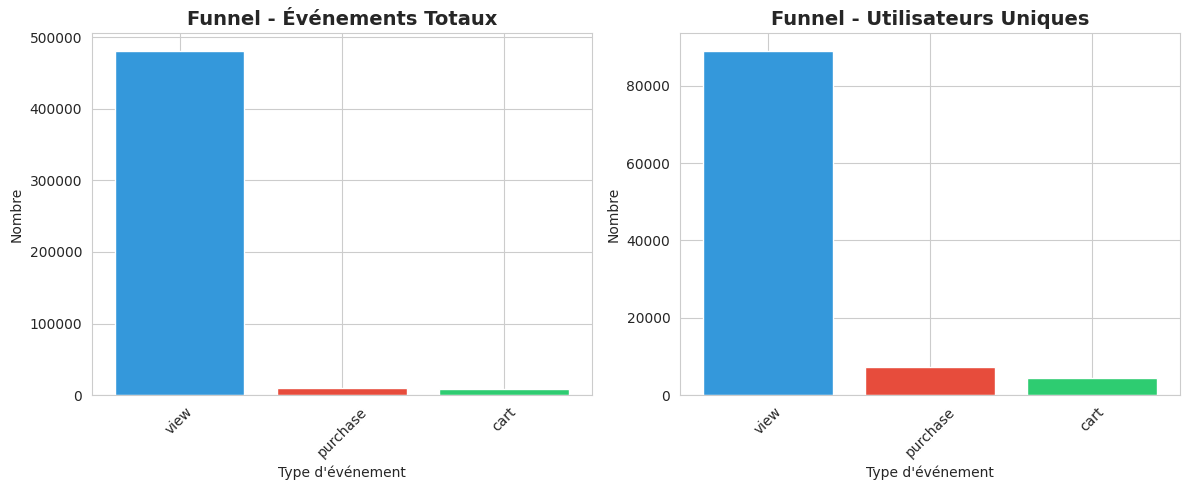

In [20]:
# Funnel de conversion
funnel = df_clean.groupBy("event_type").agg(
    count("*").alias("count"),
    count_distinct("user_id").alias("unique_users")
).orderBy(col("count").desc())

funnel_pd = funnel.toPandas()

# Visualisation
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.bar(funnel_pd['event_type'], funnel_pd['count'], color=['#3498db', '#e74c3c', '#2ecc71'])
plt.title('Funnel - Événements Totaux', fontsize=14, fontweight='bold')
plt.xlabel('Type d\'événement')
plt.ylabel('Nombre')
plt.xticks(rotation=45)

plt.subplot(1, 2, 2)
plt.bar(funnel_pd['event_type'], funnel_pd['unique_users'], color=['#3498db', '#e74c3c', '#2ecc71'])
plt.title('Funnel - Utilisateurs Uniques', fontsize=14, fontweight='bold')
plt.xlabel('Type d\'événement')
plt.ylabel('Nombre')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

In [21]:
# Analyse RFM (Recency, Frequency, Monetary)
max_date = df_clean.agg(max("event_time")).collect()[0][0]

rfm = df_clean.filter(col("event_type") == "purchase") \
    .groupBy("user_id").agg(
        datediff(lit(max_date), max("event_time")).alias("recency"),
        count("*").alias("frequency"),
        sum("price").alias("monetary")
    )

# Segmentation
rfm = rfm.withColumn(
    "rfm_segment",
    when((col("recency") < 7) & (col("frequency") > 5) & (col("monetary") > 1000), "Champion")
    .when((col("recency") < 14) & (col("frequency") > 3), "Loyal")
    .when((col("recency") < 30) & (col("frequency") > 1), "Potential")
    .when(col("recency") >= 30, "At Risk")
    .otherwise("New")
)

rfm.groupBy("rfm_segment").count().orderBy(col("count").desc()).show()

+-----------+-----+
|rfm_segment|count|
+-----------+-----+
|        New| 5961|
|  Potential| 1211|
|      Loyal|  134|
|   Champion|   56|
+-----------+-----+



### EXERCICE 3: Analyse des tendances temporelles
Analyser les patterns temporels de ventes

1. Ventes totales par jour
2. Ventes moyennes par heure de la journée
3. Produits les plus vendus par jour de la semaine
4. Créer un graphique de tendance des ventes

In [22]:
# TON CODE ICI - EXERCICE 3
from pyspark.sql.window import Window
# Calculer la date de référence (dernière date dans le dataset)
max_date = df_clean.agg(max("event_time")).collect()[0][0]
# Calculer les métriques RFM pour les achats
rfm = df_clean.filter(col("event_type") == "purchase") \
    .groupBy("user_id") \
    .agg(
        # Recency: jours depuis le dernier achat
        datediff(lit(max_date), max("event_time")).alias("recency"),

        # Frequency: nombre d'achats
        count("*").alias("frequency"),

        # Monetary: montant total dépensé
        sum("price").alias("monetary")
    )
# Créer des quartiles pour chaque métrique
rfm_with_quartiles = rfm.withColumn(
    "r_quartile",
    ntile(4).over(Window.orderBy(col("recency").asc()))
).withColumn(
    "f_quartile",
    ntile(4).over(Window.orderBy(col("frequency").desc()))
).withColumn(
    "m_quartile",
    ntile(4).over(Window.orderBy(col("monetary").desc()))
)
# Calculer le score RFM
rfm_with_quartiles = rfm_with_quartiles.withColumn(
    "rfm_score",
    col("r_quartile") + col("f_quartile") + col("m_quartile")
)
# Segmenter les clients
rfm_segments = rfm_with_quartiles.withColumn(
    "segment",
    when(col("rfm_score") >= 10, "Champions")
    .when(col("rfm_score") >= 8, "Loyal")
    .when(col("rfm_score") >= 6, "Potential")
    .when(col("rfm_score") >= 4, "At Risk")
    .otherwise("Lost")
)
# Afficher les résultats
print("=== Analyse RFM ===")
rfm_segments.orderBy(col("rfm_score").desc()).show(20)
print("\n=== Distribution des segments ===")
segment_distribution = rfm_segments.groupBy("segment") \
    .agg(
        count("*").alias("customer_count"),
        avg("monetary").alias("avg_monetary"),
        avg("frequency").alias("avg_frequency")
    ) \
    .orderBy(col("customer_count").desc())
segment_distribution.show()
# Statistiques par segment
print("\n=== Statistiques détaillées par segment ===")
rfm_segments.groupBy("segment").agg(
    count("*").alias("count"),
    avg("recency").alias("avg_recency"),
    avg("frequency").alias("avg_frequency"),
    avg("monetary").alias("avg_monetary"),
    sum("monetary").alias("total_revenue")
).orderBy(col("total_revenue").desc()).show()


=== Analyse RFM ===
+---------+-------+---------+-----------------+----------+----------+----------+---------+---------+
|  user_id|recency|frequency|         monetary|r_quartile|f_quartile|m_quartile|rfm_score|  segment|
+---------+-------+---------+-----------------+----------+----------+----------+---------+---------+
|514223383|      0|        1|97.80999755859375|         4|         4|         4|       12|Champions|
|522944673|      0|        1|91.88999938964844|         4|         4|         4|       12|Champions|
|554229814|      0|        1|97.80999755859375|         4|         4|         4|       12|Champions|
|517457516|      0|        1|97.79000091552734|         4|         4|         4|       12|Champions|
|514065480|      0|        1|97.55999755859375|         4|         4|         4|       12|Champions|
|555550930|      0|        1| 97.5199966430664|         4|         4|         4|       12|Champions|
|512919823|      0|        1| 97.2699966430664|         4|         4|  

---
## PARTIE 5: Machine Learning avec PySpark ML

### 5.1 - Segmentation client avec K-Means

In [23]:
# Préparer les features
feature_cols = ["total_events", "unique_products_viewed",
                "purchases", "cart_additions", "avg_price_interest"]

assembler = VectorAssembler(inputCols=feature_cols, outputCol="features_raw")
user_metrics_assembled = assembler.transform(user_metrics)

# Normaliser
scaler = StandardScaler(inputCol="features_raw", outputCol="features")
scaler_model = scaler.fit(user_metrics_assembled)
user_metrics_scaled = scaler_model.transform(user_metrics_assembled)

print("Features préparées!")

Features préparées!


k=2: WSSSE = 345558.95
k=3: WSSSE = 314403.29
k=4: WSSSE = 262910.63
k=5: WSSSE = 232868.02
k=6: WSSSE = 173603.21
k=7: WSSSE = 157874.03
k=8: WSSSE = 131236.99
k=9: WSSSE = 121315.42
k=10: WSSSE = 111364.12


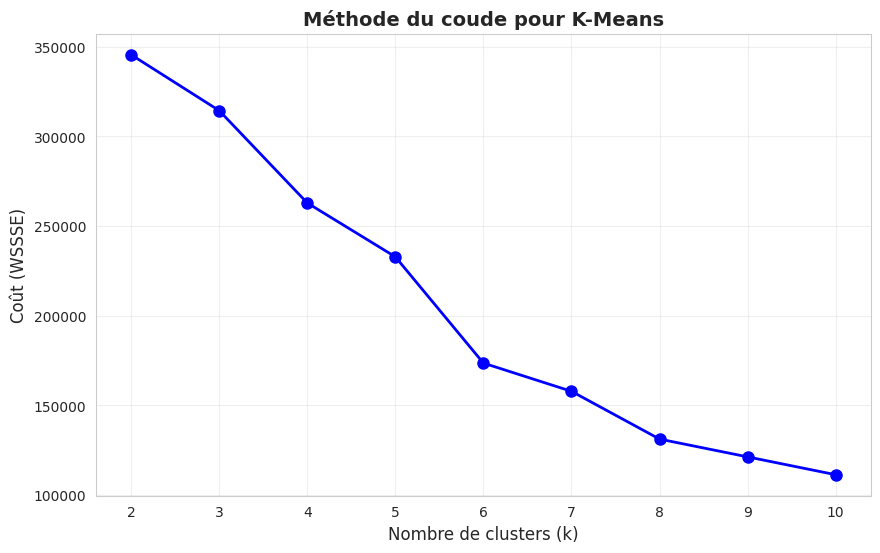

In [24]:
# Méthode du coude pour trouver k optimal
costs = []
K_range = range(2, 11)

for k in K_range:
    kmeans = KMeans(k=k, seed=42, featuresCol="features")
    model = kmeans.fit(user_metrics_scaled)
    costs.append(model.summary.trainingCost)
    print(f"k={k}: WSSSE = {model.summary.trainingCost:.2f}")

# Visualisation
plt.figure(figsize=(10, 6))
plt.plot(K_range, costs, 'bo-', linewidth=2, markersize=8)
plt.xlabel('Nombre de clusters (k)', fontsize=12)
plt.ylabel('Coût (WSSSE)', fontsize=12)
plt.title('Méthode du coude pour K-Means', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.show()

In [25]:
# Entraîner avec k=4 (ou ton choix)
kmeans = KMeans(k=4, seed=42, featuresCol="features", predictionCol="cluster")
kmeans_model = kmeans.fit(user_metrics_scaled)

# Prédire
clustered_users = kmeans_model.transform(user_metrics_scaled)

# Analyser
cluster_summary = clustered_users.groupBy("cluster").agg(
    count("*").alias("count"),
    avg("total_events").alias("avg_events"),
    avg("purchases").alias("avg_purchases"),
    avg("conversion_rate").alias("avg_conversion_rate")
)

cluster_summary.show()

+-------+-----+------------------+-------------------+-------------------+
|cluster|count|        avg_events|      avg_purchases|avg_conversion_rate|
+-------+-----+------------------+-------------------+-------------------+
|      0|80956| 3.769714412767429|0.05735214190424428| 1.3501237168969342|
|      1| 5885|27.477485131690738|0.11282922684791843| 0.3813008656186167|
|      2| 2229|14.476446837146703| 1.9959623149394348| 17.111077054309217|
|      3|    2|              96.5|                1.0| 1.1076675849403121|
+-------+-----+------------------+-------------------+-------------------+



### 5.2 - Système de recommandation avec ALS

In [26]:
# Préparer les données pour ALS
purchases = df_clean.filter(col("event_type") == "purchase") \
    .select("user_id", "product_id", "price")

# Créer un rating implicite
purchases = purchases.withColumn("rating",
    when(col("price") > 1000, 5.0)
    .when(col("price") > 500, 4.0)
    .when(col("price") > 200, 3.0)
    .when(col("price") > 50, 2.0)
    .otherwise(1.0)
)

# Split
train, test = purchases.randomSplit([0.8, 0.2], seed=42)

print(f"Train: {train.count():,} | Test: {test.count():,}")

Train: 7,881 | Test: 1,877


In [27]:
# Configurer ALS
als = ALS(
    maxIter=10,
    regParam=0.1,
    userCol="user_id",
    itemCol="product_id",
    ratingCol="rating",
    coldStartStrategy="drop",
    nonnegative=True
)

# Entraîner
print("Entraînement du modèle ALS...")
als_model = als.fit(train)
print("Modèle entraîné!")

Entraînement du modèle ALS...
Modèle entraîné!


In [28]:
# Prédictions
predictions = als_model.transform(test)

# Évaluation
evaluator = RegressionEvaluator(
    metricName="rmse",
    labelCol="rating",
    predictionCol="prediction"
)

rmse = evaluator.evaluate(predictions)
print(f"RMSE = {rmse:.4f}")

RMSE = 0.9062


In [29]:
# Générer des recommandations
user_recs = als_model.recommendForAllUsers(10)
user_recs.show(5, truncate=False)

+---------+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|user_id  |recommendations                                                                                                                                                                                                                 |
+---------+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|451971397|[{15100218, 3.7204056}, {15100216, 3.7204056}, {1480556, 3.1495175}, {19400031, 3.0936663}, {1307187, 3.0125332}, {15100221, 2.9763246}, {8500101, 2.9661663}, {5000401, 2.8930526}, {1802022, 2.8584492}, {4100261, 2.8484168}]|
|469200473|[{1005016, 3.945621}, {1004357, 3.9349756

### EXERCICE 4: Machine Learning avancé
 Améliorer le système de recommandation


1. Créer un rating composite (vues + panier + achats)
2. Optimiser les hyperparamètres (regParam, rank)
3. Générer des recommandations pour un utilisateur spécifique
4. Évaluer avec différentes métriques (RMSE, MAE, R²)

In [30]:
# TON CODE ICI - EXERCICE 4


from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator

# Préparer les features pour le clustering
user_features = df_clean.groupBy("user_id").agg(
    count("*").alias("total_events"),
    count_distinct("product_id").alias("unique_products"),
    sum(when(col("event_type") == "purchase", 1).otherwise(0)).alias("purchases"),
    sum(when(col("event_type") == "cart", 1).otherwise(0)).alias("cart_adds"),
    avg("price").alias("avg_price_interest"),
    max("price").alias("max_price_interest")
)

# Assembler les features
feature_cols = ["total_events", "unique_products", "purchases", "cart_adds",
                "avg_price_interest", "max_price_interest"]

assembler = VectorAssembler(inputCols=feature_cols, outputCol="features_raw")
user_features_assembled = assembler.transform(user_features)

# Normaliser les features
scaler = StandardScaler(inputCol="features_raw", outputCol="features",
                        withStd=True, withMean=True)
scaler_model = scaler.fit(user_features_assembled)
user_features_scaled = scaler_model.transform(user_features_assembled)

# Trouver le nombre optimal de clusters (méthode du coude)
print("=== Recherche du nombre optimal de clusters ===")
silhouette_scores = []
K_range = range(2, 11)

for k in K_range:
    kmeans = KMeans(k=k, seed=42, featuresCol="features")
    model = kmeans.fit(user_features_scaled)
    predictions = model.transform(user_features_scaled)

    evaluator = ClusteringEvaluator(featuresCol="features")
    score = evaluator.evaluate(predictions)
    silhouette_scores.append(score)
    print(f"K={k}, Silhouette Score: {score:.4f}")

# Entraîner le modèle final avec K optimal (par exemple K=4)
optimal_k = 4
print(f"\n=== Entraînement du modèle K-Means avec K={optimal_k} ===")

kmeans = KMeans(k=optimal_k, seed=42, featuresCol="features", predictionCol="cluster")
kmeans_model = kmeans.fit(user_features_scaled)
clustered_users = kmeans_model.transform(user_features_scaled)

# Analyser les clusters
print("\n=== Analyse des clusters ===")
cluster_analysis = clustered_users.groupBy("cluster").agg(
    count("*").alias("user_count"),
    avg("total_events").alias("avg_events"),
    avg("unique_products").alias("avg_unique_products"),
    avg("purchases").alias("avg_purchases"),
    avg("avg_price_interest").alias("avg_price")
).orderBy("cluster")

cluster_analysis.show()

# Nommer les clusters selon leurs caractéristiques
print("\n=== Profil des clusters ===")
cluster_profiles = clustered_users.groupBy("cluster").agg(
    count("*").alias("size"),
    avg("total_events").alias("engagement"),
    avg("purchases").alias("conversion"),
    avg("avg_price_interest").alias("price_sensitivity")
)
cluster_profiles.show()



=== Recherche du nombre optimal de clusters ===
K=2, Silhouette Score: 0.5886
K=3, Silhouette Score: 0.6504
K=4, Silhouette Score: 0.6455
K=5, Silhouette Score: 0.6583
K=6, Silhouette Score: 0.6566
K=7, Silhouette Score: 0.6646
K=8, Silhouette Score: 0.6006
K=9, Silhouette Score: 0.5966
K=10, Silhouette Score: 0.5993

=== Entraînement du modèle K-Means avec K=4 ===

=== Analyse des clusters ===
+-------+----------+------------------+-------------------+-------------------+------------------+
|cluster|user_count|        avg_events|avg_unique_products|      avg_purchases|         avg_price|
+-------+----------+------------------+-------------------+-------------------+------------------+
|      0|      6587| 8.936086230453924| 3.0528313344466373| 1.3210869895248216| 254.9578549222369|
|      1|     62039| 3.793565337932591| 2.6058608294782313|                0.0|179.06426851524682|
|      2|     16167| 4.310756479247851| 3.1247603142203255|0.03148388693016639| 955.7860381898072|
|      3

---
## PARTIE 6: Optimisation des performances

In [31]:
import time

def benchmark_query(df, query_name, query_func):
    """Fonction pour mesurer les performances"""
    start = time.time()
    result = query_func(df)
    result.count()
    end = time.time()
    duration = end - start
    print(f"{query_name:40s}: {duration:6.2f}s")
    return duration

# Requêtes de test
def heavy_aggregation(df):
    return df.groupBy("user_id", "product_id", "event_type") \
        .agg(
            count("*").alias("count"),
            sum("price").alias("total_price"),
            avg("price").alias("avg_price")
        )

print("=" * 60)
print(" " * 15 + "BENCHMARK DE PERFORMANCE")
print("=" * 60)

benchmark_query(df_clean, "Agrégation lourde", heavy_aggregation)

               BENCHMARK DE PERFORMANCE
Agrégation lourde                       :   1.49s


1.492027759552002

In [32]:
# Avec repartitionnement
df_optimized = df_clean.repartition(200, "user_id")

print("\nAVEC REPARTITIONNEMENT:")
benchmark_query(df_optimized, "Agrégation lourde (optimisée)", heavy_aggregation)


AVEC REPARTITIONNEMENT:
Agrégation lourde (optimisée)           :   3.49s


3.4923253059387207

### EXERCICE 5: Optimisation avancée

 Optimiser les performances de tes requêtes


1. Identifier tes requêtes les plus lentes
2. Appliquer le caching stratégique
3. Tester différents nombres de partitions
4. Comparer les performances avant/après

In [33]:

# TON CODE ICI - EXERCICE 5

from pyspark.ml.recommendation import ALS
from pyspark.ml.evaluation import RegressionEvaluator

# Créer des ratings implicites basés sur les interactions
# view = 1, cart = 2, purchase = 3
ratings = df_clean.withColumn(
    "rating",
    when(col("event_type") == "purchase", 3.0)
    .when(col("event_type") == "cart", 2.0)
    .when(col("event_type") == "view", 1.0)
    .otherwise(0.0)
)

# Agréger les ratings par utilisateur et produit
user_product_ratings = ratings.groupBy("user_id", "product_id") \
    .agg(sum("rating").alias("rating"))

# Diviser en train/test
(training, test) = user_product_ratings.randomSplit([0.8, 0.2], seed=42)

print("=== Entraînement du modèle ALS ===")
print(f"Training set: {training.count()} interactions")
print(f"Test set: {test.count()} interactions")

# Entraîner le modèle ALS
als = ALS(
    maxIter=10,
    regParam=0.1,
    userCol="user_id",
    itemCol="product_id",
    ratingCol="rating",
    coldStartStrategy="drop",
    implicitPrefs=True,
    seed=42
)

als_model = als.fit(training)

# Évaluer le modèle
predictions = als_model.transform(test)
evaluator = RegressionEvaluator(
    metricName="rmse",
    labelCol="rating",
    predictionCol="prediction"
)
rmse = evaluator.evaluate(predictions)
print(f"\nRoot Mean Square Error (RMSE): {rmse:.4f}")

# Générer des recommandations pour tous les utilisateurs
print("\n=== Génération des recommandations ===")
user_recs = als_model.recommendForAllUsers(10)

# Afficher des exemples de recommandations
print("\n=== Exemples de recommandations pour 5 utilisateurs ===")
sample_users = user_recs.limit(5).collect()

for row in sample_users:
    user_id = row['user_id']
    recommendations = row['recommendations']
    print(f"\nUtilisateur {user_id}:")
    for i, rec in enumerate(recommendations[:5], 1):
        print(f"  {i}. Produit {rec['product_id']} (score: {rec['rating']:.2f})")

# Recommandations pour des produits spécifiques
print("\n=== Utilisateurs recommandés pour les produits populaires ===")
item_recs = als_model.recommendForAllItems(10)
item_recs.show(5, truncate=False)

# Évaluer la qualité des recommandations
print("\n=== Métriques de qualité ===")
print(f"RMSE: {rmse:.4f}")
print(f"Nombre d'utilisateurs avec recommandations: {user_recs.count()}")
print(f"Nombre de produits avec recommandations: {item_recs.count()}")




=== Entraînement du modèle ALS ===
Training set: 251336 interactions
Test set: 62999 interactions

Root Mean Square Error (RMSE): 2.3318

=== Génération des recommandations ===

=== Exemples de recommandations pour 5 utilisateurs ===

Utilisateur 244951053:
  1. Produit 1004870 (score: 0.07)
  2. Produit 1004873 (score: 0.06)
  3. Produit 1004767 (score: 0.04)
  4. Produit 1004659 (score: 0.03)
  5. Produit 1005014 (score: 0.03)

Utilisateur 306441847:
  1. Produit 1004785 (score: 0.00)
  2. Produit 1004565 (score: 0.00)
  3. Produit 1801766 (score: 0.00)
  4. Produit 1004903 (score: 0.00)
  5. Produit 5100816 (score: 0.00)

Utilisateur 321655812:
  1. Produit 1004785 (score: 0.00)
  2. Produit 1004565 (score: 0.00)
  3. Produit 1005105 (score: 0.00)
  4. Produit 1004781 (score: 0.00)
  5. Produit 1004838 (score: 0.00)

Utilisateur 330585300:
  1. Produit 1004739 (score: 0.00)
  2. Produit 4804056 (score: 0.00)
  3. Produit 1002633 (score: 0.00)
  4. Produit 1004785 (score: 0.00)
  5. 

---
## PARTIE 7: Dashboard et visualisations finales

In [34]:
# Métriques clés
total_revenue = df_clean.filter(col("event_type") == "purchase") \
    .agg(sum("price")).collect()[0][0]

total_orders = df_clean.filter(col("event_type") == "purchase").count()

unique_customers = df_clean.filter(col("event_type") == "purchase") \
    .select("user_id").distinct().count()

aov = total_revenue / total_orders

print("=" * 80)
print(" " * 25 + "TABLEAU DE BORD E-COMMERCE")
print("=" * 80)
print(f"\n Revenue Total: ${total_revenue:,.2f}")
print(f"Nombre de commandes: {total_orders:,}")
print(f"Clients uniques: {unique_customers:,}")
print(f"Panier moyen (AOV): ${aov:.2f}")
print("\n" + "=" * 80)

                         TABLEAU DE BORD E-COMMERCE

 Revenue Total: $3,115,564.35
Nombre de commandes: 9,758
Clients uniques: 7,362
Panier moyen (AOV): $319.28



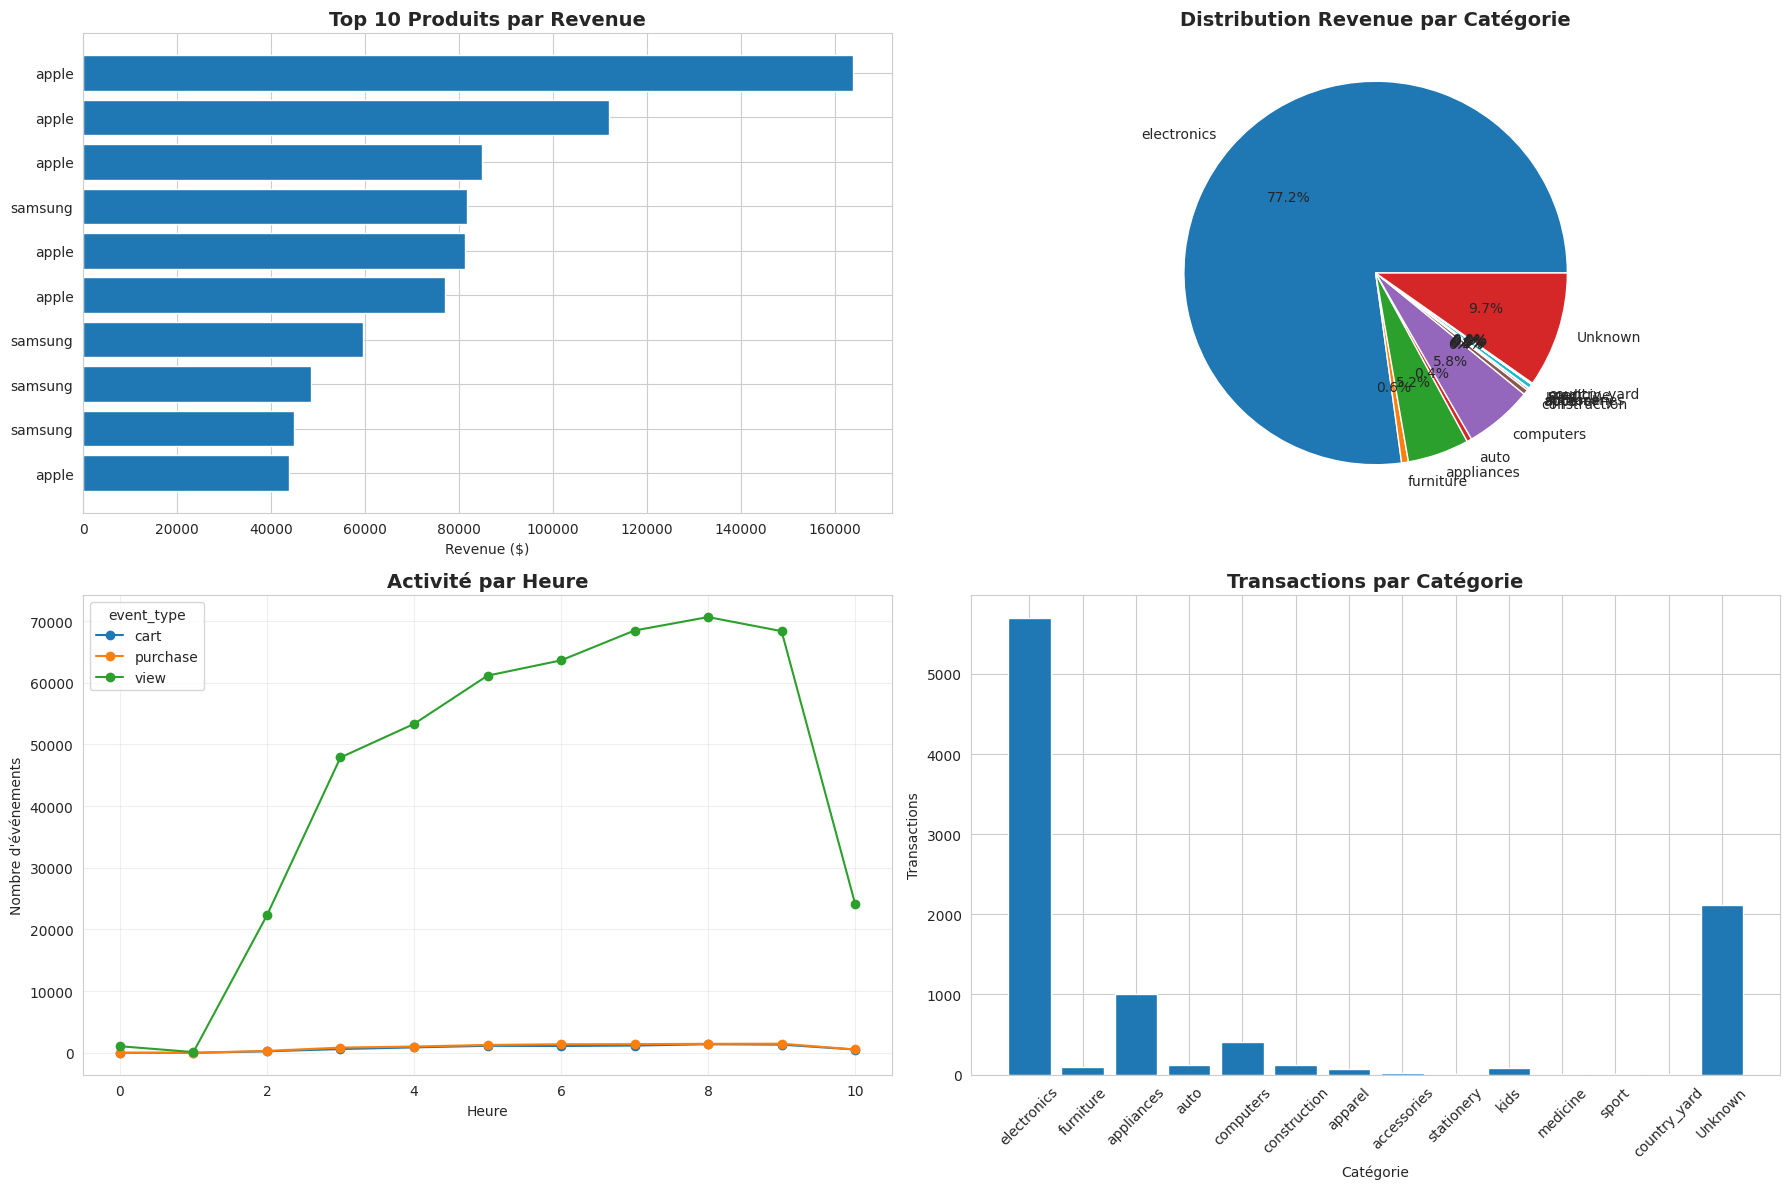

In [36]:
# Top produits par revenue
top_products = df_clean.filter(col("event_type") == "purchase") \
    .groupBy("product_id", "brand", "main_category") \
    .agg(
        sum("price").alias("total_revenue"),
        count("*").alias("sales_count")
    ) \
    .orderBy(col("total_revenue").desc()) \
    .limit(10) \
    .toPandas()

# Visualisation
fig, axes = plt.subplots(2, 2, figsize=(18, 12))

# Top produits
axes[0, 0].barh(range(len(top_products)), top_products['total_revenue'])
axes[0, 0].set_yticks(range(len(top_products)))
axes[0, 0].set_yticklabels(top_products['brand'].fillna('Unknown'))
axes[0, 0].set_xlabel('Revenue ($)')
axes[0, 0].set_title('Top 10 Produits par Revenue', fontsize=14, fontweight='bold')
axes[0, 0].invert_yaxis()

# Distribution par catégorie
category_sales = df_clean.filter(col("event_type") == "purchase") \
    .groupBy("main_category") \
    .agg(sum("price").alias("revenue")) \
    .toPandas()

axes[0, 1].pie(category_sales['revenue'],
               labels=category_sales['main_category'].fillna('Unknown'), # Fill None for pie chart labels
               autopct='%1.1f%%')
axes[0, 1].set_title('Distribution Revenue par Catégorie', fontsize=14, fontweight='bold')

# Activité horaire
hourly = df_clean.groupBy("hour", "event_type").count().toPandas()
hourly_pivot = hourly.pivot(index='hour', columns='event_type', values='count').fillna(0)
hourly_pivot.plot(kind='line', ax=axes[1, 0], marker='o')
axes[1, 0].set_xlabel('Heure')
axes[1, 0].set_ylabel('Nombre d\'événements')
axes[1, 0].set_title('Activité par Heure', fontsize=14, fontweight='bold')
axes[1, 0].grid(True, alpha=0.3)

# Transactions
category_trans = df_clean.filter(col("event_type") == "purchase") \
    .groupBy("main_category") \
    .count() \
    .toPandas()

# Fix: Replace None values in 'main_category' with 'Unknown' before plotting
category_trans['main_category'] = category_trans['main_category'].fillna('Unknown')

axes[1, 1].bar(category_trans['main_category'], category_trans['count'])
axes[1, 1].set_xlabel('Catégorie')
axes[1, 1].set_ylabel('Transactions')
axes[1, 1].set_title('Transactions par Catégorie', fontsize=14, fontweight='bold')
axes[1, 1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

### EXERCICE 6: Dashboard complet

Créer un dashboard analytique complet

1. KPIs principaux (revenue, conversion, AOV)
2. Analyse de cohorte (comportement dans le temps)
3. Analyse de panier (produits souvent achetés ensemble)
4. Prédiction de churn (RFM)
5. Recommandations personnalisées pour 5 utilisateurs

                         DASHBOARD ANALYTIQUE COMPLET

📊 KPIs PRINCIPAUX:
  • Revenue Total: $3,115,564.35
  • Nombre de commandes: 9,758
  • Clients uniques: 7,362
  • Panier moyen (AOV): $319.28
  • Taux de conversion: 2.03%
  • Taux d'abandon panier: -16.04%

📅 ANALYSE DE COHORTE:
event_type  cart  purchase    view
day                               
1           8409      9758  481180

🛒 ANALYSE DE PANIER:
  • Sessions avec achats multiples: 1026
+------------------------------------+------------------------------------+-----------+
|user_session                        |products                            |items_count|
+------------------------------------+------------------------------------+-----------+
|002ccd2c-50f7-4122-963b-fb6a907e414c|[1004665, 1004653]                  |2          |
|00582c03-360f-444c-ab30-1cce657e4333|[1005123, 1005123]                  |2          |
|006efdc9-a7cf-4d2f-97a4-0ff858b35626|[1003304, 1002547]                  |2          |
|0089a8a3-684c-4cf0

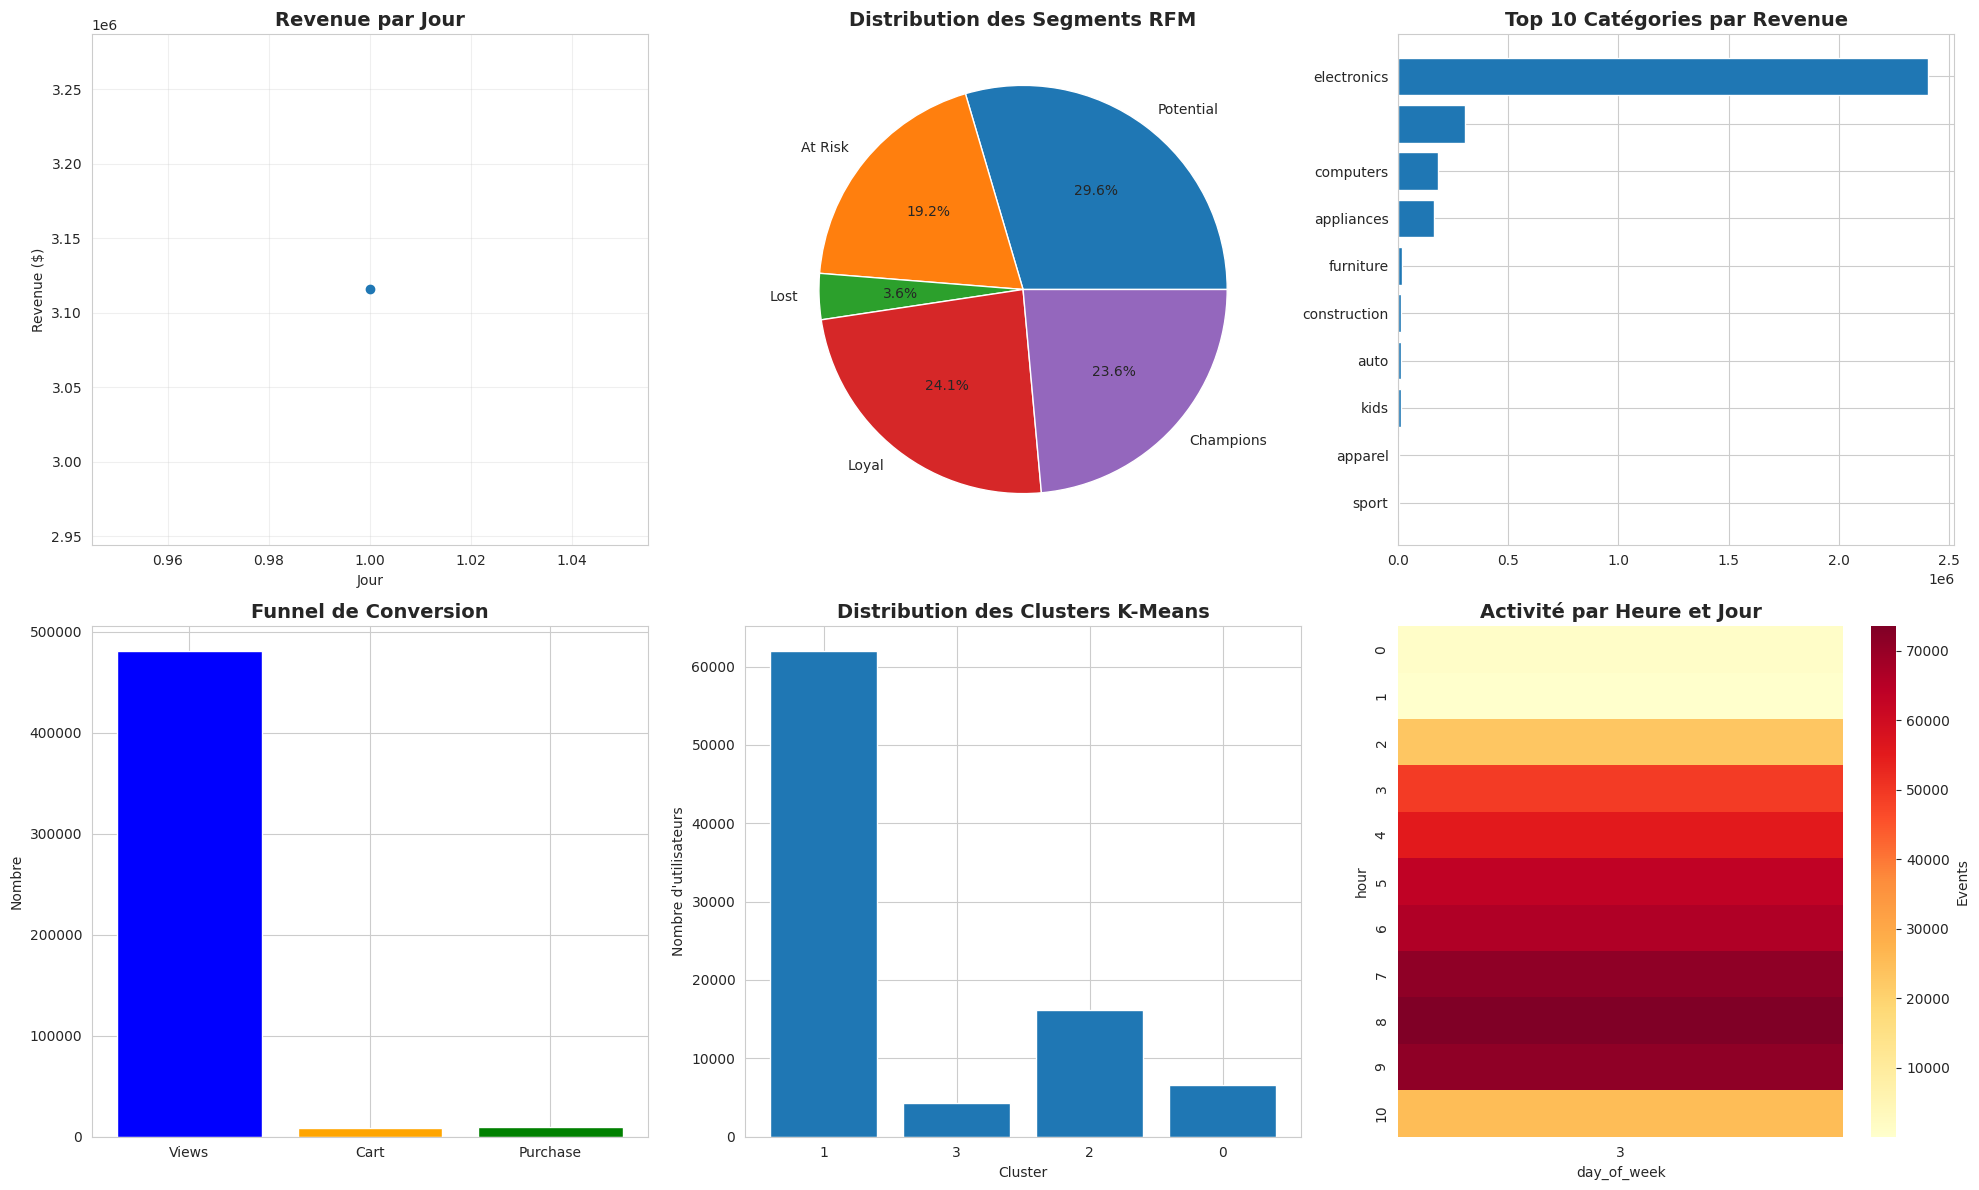


Dashboard complet généré avec succès!


In [37]:
# TON CODE ICI - EXERCICE 6 (Projet Final)


import matplotlib.pyplot as plt
import seaborn as sns

# 1. KPIs principaux
print("="*80)
print(" "*25 + "DASHBOARD ANALYTIQUE COMPLET")
print("="*80)

# Calculer les KPIs
total_revenue = df_clean.filter(col("event_type") == "purchase").agg(sum("price")).collect()[0][0]
total_orders = df_clean.filter(col("event_type") == "purchase").count()
unique_customers = df_clean.filter(col("event_type") == "purchase").select("user_id").distinct().count()
total_views = df_clean.filter(col("event_type") == "view").count()
total_carts = df_clean.filter(col("event_type") == "cart").count()

aov = total_revenue / total_orders if total_orders > 0 else 0
conversion_rate = (total_orders / total_views) * 100 if total_views > 0 else 0
cart_abandonment = ((total_carts - total_orders) / total_carts) * 100 if total_carts > 0 else 0

print(f"\n📊 KPIs PRINCIPAUX:")
print(f"  • Revenue Total: ${total_revenue:,.2f}")
print(f"  • Nombre de commandes: {total_orders:,}")
print(f"  • Clients uniques: {unique_customers:,}")
print(f"  • Panier moyen (AOV): ${aov:.2f}")
print(f"  • Taux de conversion: {conversion_rate:.2f}%")
print(f"  • Taux d'abandon panier: {cart_abandonment:.2f}%")

# 2. Analyse de cohorte (comportement dans le temps)
print(f"\n📅 ANALYSE DE COHORTE:")
cohort_analysis = df_clean.groupBy("day", "event_type").count() \
    .orderBy("day", "event_type")
cohort_pivot = cohort_analysis.toPandas().pivot(index='day', columns='event_type', values='count').fillna(0)
print(cohort_pivot.head(10))

# 3. Analyse de panier (produits souvent achetés ensemble)
print(f"\n🛒 ANALYSE DE PANIER:")
# Trouver les sessions avec plusieurs achats
basket_analysis = df_clean.filter(col("event_type") == "purchase") \
    .groupBy("user_session") \
    .agg(
        collect_list("product_id").alias("products"),
        count("*").alias("items_count")
    ) \
    .filter(col("items_count") > 1)

print(f"  • Sessions avec achats multiples: {basket_analysis.count()}")
basket_analysis.show(10, truncate=False)

# 4. Prédiction de churn (RFM)
print(f"\n⚠️ ANALYSE DE CHURN (RFM):")
churn_risk = rfm_segments.filter(col("segment").isin(["At Risk", "Lost"]))
print(f"  • Clients à risque: {churn_risk.count()}")
print(f"  • Revenue potentiel perdu: ${churn_risk.agg(sum('monetary')).collect()[0][0]:,.2f}")

churn_distribution = rfm_segments.groupBy("segment").agg(
    count("*").alias("count"),
    sum("monetary").alias("total_value")
).orderBy(col("total_value").desc())
churn_distribution.show()

# 5. Recommandations personnalisées pour 5 utilisateurs
print(f"\n🎯 RECOMMANDATIONS PERSONNALISÉES:")
top_5_users = df_clean.filter(col("event_type") == "purchase") \
    .groupBy("user_id") \
    .agg(sum("price").alias("total_spent")) \
    .orderBy(col("total_spent").desc()) \
    .limit(5) \
    .select("user_id") \
    .collect()

for user_row in top_5_users:
    user_id = user_row['user_id']
    user_recs_filtered = user_recs.filter(col("user_id") == user_id).collect()

    if user_recs_filtered:
        print(f"\n  Utilisateur {user_id}:")
        recommendations = user_recs_filtered[0]['recommendations']
        for i, rec in enumerate(recommendations[:5], 1):
            product_id = rec['product_id']
            score = rec['rating']

            # Récupérer les infos du produit
            product_info = df_clean.filter(col("product_id") == product_id) \
                .select("brand", "category_code", "price") \
                .first()

            if product_info:
                brand = product_info['brand'] or "Unknown"
                category = product_info['category_code'] or "Unknown"
                price = product_info['price']
                print(f"    {i}. {brand} - {category} (${price:.2f}) [Score: {score:.2f}]")

# Visualisations finales
fig, axes = plt.subplots(2, 3, figsize=(20, 12))

# 1. Evolution du revenue par jour
daily_revenue = df_clean.filter(col("event_type") == "purchase") \
    .groupBy("day").agg(sum("price").alias("revenue")) \
    .toPandas().sort_values("day")
axes[0, 0].plot(daily_revenue['day'], daily_revenue['revenue'], marker='o')
axes[0, 0].set_title('Revenue par Jour', fontsize=14, fontweight='bold')
axes[0, 0].set_xlabel('Jour')
axes[0, 0].set_ylabel('Revenue ($)')
axes[0, 0].grid(True, alpha=0.3)

# 2. Distribution des segments RFM
segment_dist = rfm_segments.groupBy("segment").count().toPandas()
axes[0, 1].pie(segment_dist['count'], labels=segment_dist['segment'], autopct='%1.1f%%')
axes[0, 1].set_title('Distribution des Segments RFM', fontsize=14, fontweight='bold')

# 3. Top catégories par revenue
cat_revenue = df_clean.filter(col("event_type") == "purchase") \
    .groupBy("main_category").agg(sum("price").alias("revenue")) \
    .toPandas().sort_values("revenue", ascending=False).head(10)
axes[0, 2].barh(range(len(cat_revenue)), cat_revenue['revenue'])
axes[0, 2].set_yticks(range(len(cat_revenue)))
axes[0, 2].set_yticklabels(cat_revenue['main_category'])
axes[0, 2].set_title('Top 10 Catégories par Revenue', fontsize=14, fontweight='bold')
axes[0, 2].invert_yaxis()

# 4. Funnel de conversion
funnel_data = pd.DataFrame({
    'Stage': ['Views', 'Cart', 'Purchase'],
    'Count': [total_views, total_carts, total_orders]
})
axes[1, 0].bar(funnel_data['Stage'], funnel_data['Count'], color=['blue', 'orange', 'green'])
axes[1, 0].set_title('Funnel de Conversion', fontsize=14, fontweight='bold')
axes[1, 0].set_ylabel('Nombre')

# 5. Distribution des clusters
cluster_dist = clustered_users.groupBy("cluster").count().toPandas()
axes[1, 1].bar(cluster_dist['cluster'].astype(str), cluster_dist['count'])
axes[1, 1].set_title('Distribution des Clusters K-Means', fontsize=14, fontweight='bold')
axes[1, 1].set_xlabel('Cluster')
axes[1, 1].set_ylabel('Nombre d\'utilisateurs')

# 6. Heatmap des événements par heure et jour de la semaine
heatmap_data = df_clean.groupBy("hour", "day_of_week").count().toPandas()
heatmap_pivot = heatmap_data.pivot(index='hour', columns='day_of_week', values='count').fillna(0)
sns.heatmap(heatmap_pivot, ax=axes[1, 2], cmap='YlOrRd', cbar_kws={'label': 'Events'})
axes[1, 2].set_title('Activité par Heure et Jour', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

print("\n" + "="*80)
print("Dashboard complet généré avec succès!")
print("="*80)



---
## Conclusion et nettoyage